<Task pending name='Task-1' coro=<main() running at <ipython-input-1-5a748e7b56a0>:38>>

Running total 510 batches
 - processing batch No.0, the job has took 0.00 seconds.
 - Has found I-765: 0
 - processing batch No.10, the job has took 52.55 seconds.
 - Has found I-765: 10
 - processing batch No.20, the job has took 104.08 seconds.
 - Has found I-765: 33
 - processing batch No.30, the job has took 147.60 seconds.
 - Has found I-765: 65
 - processing batch No.40, the job has took 180.62 seconds.
 - Has found I-765: 99
 - processing batch No.50, the job has took 222.26 seconds.
 - Has found I-765: 140
 - processing batch No.60, the job has took 265.67 seconds.
 - Has found I-765: 181
 - processing batch No.70, the job has took 300.69 seconds.
 - Has found I-765: 198
Error with EAC2090109488, code 503
 - processing batch No.80, the job has took 351.32 seconds.
 - Has found I-765: 228
 - processing batch No.90, the job has took 388.78 seconds.
 - Has found I-765: 273
 - processing batch No.100, the job has took 429.20 seconds.
 - Has found I-765: 298
 - processing batch No.1

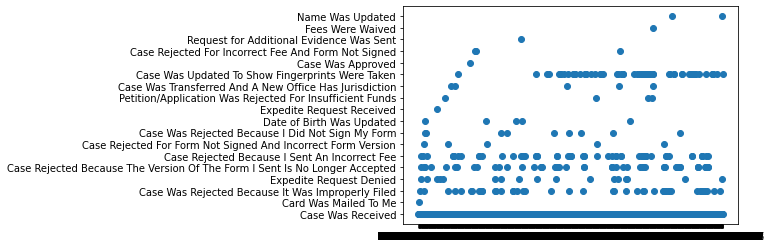

In [1]:
import time
import asyncio
import concurrent.futures
import requests
import matplotlib.pyplot as plt

RECEIPT_NUMBER_BASE = "EAC2090"
RANGE_START = 108700
RANGE_END = 114300
CASE_TYPE = 'I-765'
CONCURRENCY_LEVEL = 11


def check_status(receipt_num):
    #print(receipt_num)
    pload = {"appReceiptNum": receipt_num, "initCaseSearch":"CHECK STATUS"}
    r = requests.post('https://egov.uscis.gov/casestatus/mycasestatus.do', data=pload)
    if (r.status_code != 200):
        print("Error with {0}, code {1}".format(receipt_num, r.status_code))
        return None
    
    response = r.text.split("\n")
    if CASE_TYPE in response[733]:
        #print(receipt_num, response[719].strip())
        return (receipt_num, response[719].strip())
    else:
        return None


def save_plot(status_list):
    x, y = zip(*status_list)
    plt.scatter(x, y)
    plt.show()
    plt.savefig('UscisStats.png', bbox_inches='tight')

status_list = []

async def main():
    num_digits = len(str(RANGE_END))

    loop = asyncio.get_event_loop()
    batches = int((RANGE_END - RANGE_START) / CONCURRENCY_LEVEL + 1)
    print("Running total {} batches".format(batches))
    start = time.time()
    for i in range(batches):
        if i % 10 == 0:
            seconds = time.time() - start
            print(" - processing batch No.{0}, the job has took {1:.2f} seconds.".format(i, seconds))
            print(" - Has found I-765: {}".format(len(status_list)))
        batch_start = RANGE_START + CONCURRENCY_LEVEL * i
        with concurrent.futures.ThreadPoolExecutor(max_workers=CONCURRENCY_LEVEL) as executor:
            loop = asyncio.get_event_loop()
            futures = [
                loop.run_in_executor(
                    executor,
                    check_status,
                    RECEIPT_NUMBER_BASE + str(batch_start+x).zfill(num_digits)
                )
                for x in range(CONCURRENCY_LEVEL)
            ]
            for t in await asyncio.gather(*futures):
                if t is not None:
                    status_list.append(t)
            
                    
    print('{0} takes {1:.2f}% in the range.'.format(CASE_TYPE, 100*len(status_list)/(batches*CONCURRENCY_LEVEL)))

    save_plot(status_list)


loop = asyncio.get_event_loop()
loop.create_task(main())

In [4]:
len(status_list)

1480

In [8]:
import json

with open("today.json", 'w') as outfile:
    json.dump(status_list, outfile)